# Simulate group size

Here we simulate the distribution of group sizes f(x)

In [5]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint
final_fig_path = "../Figures/"

## To-do:
* check that the group sizes are at equilibrium!
* plot expected group size membership for different params

# Group Formation Model

In [6]:

'''
calls fun_dfdt for the different x's
params is a dictionary of the parameters
'''
def group_formation_model(f_of_x_vec,t,p,M1,M2,params):
    x_max = params["x_max"]
    dfdt = f_of_x_vec.copy() # making vector of same size, what's in it doesn't matter
    for x in range(2,x_max+1):
        dfdt[x-2] = fun_dfdt(f_of_x_vec, x, p, M1, M2, **params)
    return dfdt

'''
fun_dfdt: This calculates the change in the distribution f(x) wrt time for x >= 2


f(x) is the number of groups of size x
f_of_x_vec is a vector of f(x) for x = 2, .., x_max.

τx df/dt = -xf(x)ϕ(x) - f(1) f(x) ψ(x) - f(x) D(x) 
            + f(x+1)ϕ(x+1) + sum_{y=x+1}^{x_max} f(y) D(y)
            
TO-DO: What to do if x = x_max?
'''
def fun_dfdt(f_of_x_vec, x, p, M1, M2,  τx, δ, x_max, **params):

    # get f(x), f(1), and f(x+1)
    
    def f(y):
        if y == 1:
            return p - sum([z*f(z) for z in range(2,x_max+1)]) # this is recursively designed
        if y >= 2 and y <= x_max:
            return f_of_x_vec[y-2]
        else:
            return 0
        #return(fun_f_of_x(y,x_max,**params))

    def D_tot(y):
        return fun_1_death(y, τx, δ, **params)
    def D(z1,z2):
        # probability group of size z2 shrinks to group of size z1 for z1 \leq x_max  
        return fun_death_y_to_x(z1,z2, τx, δ, x_max, **params) if z2 <= x_max else 0
    def ϕ(y):
        # probability individual leaves group of size y for y <= x_max
        return fun_leave_group(y, M1, M2, x_max, **params) if y<= x_max else 0
    def ψ(y):
        return fun_join_group(y, M1, M2, x_max, **params) if y < x_max else 0
    
        
    individual_leaves = x*f(x) * ϕ(x)
    grows_to_larger_group = f(1)*f(x) * ψ(x)
    death_in_group = f(x) * D_tot(x)
    
    if x == 2:
        #join_smaller_grp = f(1)*f(x-1)*ψ(x-1)
        join_smaller_grp = (1/2)*f(1)*(f(1)-1)*ψ(1)
    else:
        join_smaller_grp = f(1)*f(x-1)*ψ(x-1)
            
    #join_smaller_grp = f(1)*f(x-1)*ψ(x-1)
    larger_grp_shrinks = (x+1)*f(x+1)*ϕ(x+1)
    death_in_larger_grp = sum([f(y)*D(x,y) for y in range(x+1,x_max+1)])
        
    #dfdt_times_taux = x*f_of_x*fun_leave_group(x) - 
    
    
    return 1/τx * (-individual_leaves - grows_to_larger_group - death_in_group  
                  + join_smaller_grp + larger_grp_shrinks + death_in_larger_grp)

'''

'''
def fun_f_of_x(y, f_of_x_vec, p, x_max,**params):
    if y == 1:
            return p - sum([z*f_of_x_vec[z-2] \
                            for z in range(2,x_max+1)]) 
    if y >= 2 and y <= x_max:
        return f_of_x_vec[y-2]
    else:
        return 0
    
'''
The probability an individual leaves a group of size x.
This is ϕ(x) in the text
FILL IN
'''
def fun_leave_group(x, M1, M2, x_max, **params):
    return best_response_fun(1,x,M1,M2,**params)

'''
The probability an individual joins a group of size x.
This is ψ(x) in the text
FILL IN
'''
def fun_join_group(x, M1, M2, x_max, **params):
    # deciding between being alone or being in a group of size x + 1
    return best_response_fun(x+1,1,M1,M2,**params)
'''
Compares W(x) to W(y) to "decide" on group size y or x
'''
def best_response_fun(x,y,M1,M2, d, **params):
    W_of_x = fun_fitness(x,M1,M2, **params)
    W_of_y = fun_fitness(y, M1, M2, **params)
    return W_of_x**d/(W_of_x**d + W_of_y**d)

def nchoosek(n,k):
    return sp.special.factorial(n)/(sp.special.factorial(k)*sp.special.factorial(n-k))

'''
The probability a group of size y shrinks to a group of size x because y - x individuals die, 
# works for for x < y, y <= x_max
'''
def fun_death_y_to_x(x, y, τx, δ, x_max, **params):
    
    return nchoosek(y,y-x) * (δ*τx)**(y-x)*(1-δ*τx)**x

def fun_1_death(x, τx, δ, **params):
    return 1 - (1 - δ*τx)**x


'''
this is the fitness of being in a group
for now we have a sigmoidal function of x multiplied by 1/x, 
indicating profits of being a group but then sharing
'''
def fun_fitness(x, M1, M2,b1, b2, r, γ,**params):
    wgroup = b1*fun_response(x,M1,M2,1,**params) + b2*fun_response(x,M1,M2,2,**params)
    try:
        if x > 1:
            repro_exchange = (1-γ)*(1-r) + r*x
            return 1/x*(wgroup) * repro_exchange
        else:
            return wgroup
    except ValueError:
        repro_exchange = np.ones(np.shape(x))
        repro_exchange[x>1] = (1-γ)*(1-r) + r*x[x>1]
        return (1/x)*wgroup * repro_exchange
'''
portion of fitness from each prey type, separately
'''
'''
portion of fitness from each prey type, separately
'''
def fitness_from_prey(x, M1, M2,b1, b2, r, γ,**params):
    
    wgroup = np.array([b1*fun_response(x,M1,M2,1,**params), b2*fun_response(x,M1,M2,2,**params)])
    try:
        if x > 1:
            repro_exchange = (1-γ)*(1-r) + r*x
            return 1/x *(wgroup) * repro_exchange
        else:
            return wgroup
    except ValueError:
        repro_exchange = np.ones(np.shape(x))
        repro_exchange[x>1] = (1-γ)*(1-r) + r*x[x>1]
        return (1/x) * wgroup * repro_exchange
def fun_fitness_from_big_prey(x, M1, M2, **params):
    return fitness_from_prey(x, M1, M2, **params)[0]
def fun_fitness_from_small_prey(x, M1, M2, **params):
    return fitness_from_prey(x, M1, M2, **params)[1]
    
    
    
def fun_response(x,M1,M2,index,a1,a2,h1,h2,**params):
    α1 = fun_attack_rate(x,1,**params)
    α2 = fun_attack_rate(x,2,**params)
    if index == 1:
        numerator = a1*α1*M1
    elif index == 2:
        numerator = a2*α2*M2
    denominator = 1 + a1*α1*h1*M1 + a2*α2*h2*M2
    return numerator/denominator

def fun_attack_rate(x, index, α1_of_1, α2_of_1, s1, s2, **params):
    if index == 1:
        θ_1 = - np.log(1/α1_of_1 - 1)/(1-s1)
        return 1/(1 + np.exp(- θ_1 * (x - s1)))
    elif index == 2:
        θ_2 = - np.log(1/α2_of_1 - 1)/(1-s2)
        return 1/(1 + np.exp(- θ_2 * (x - s2)))
    
def fun_num_groups(f_of_x_vec,p,x_max):
    total = 0
    for x in range(1,x_max+1):
        total += fun_f_of_x(x, f_of_x_vec, p, x_max,**dict())
    return total

'''
checks that dfdt = 0
needs to be checked
'''
def check_at_equilibrium(f_of_x_vec, p, M1, M2,  x_max,**params):
    for x in range(2, x_max+1):
        dfdt = fun_dfdt(f_of_x_vec, x, p, M1, M2, x_max=x_max,**params)
        at_equilibrium = np.abs(dfdt)<1e-10
        if not at_equilibrium:
            return 0
    return 1

# Measures

In [127]:
'''
average group size any individual is in
this is not the same as the average group size
'''
def mean_group_size_membership(f_of_x_vec,p,x_max):
    if len(f_of_x_vec) < x_max:
        total = sum([x**2*fun_f_of_x(x,f_of_x_vec,p,x_max,**dict()) \
                     for x in range(1,x_max+1)])
    elif len(f_of_x_vec) == x_max:
        total = sum([x**2*f_of_x_vec[x-1] \
                     for x in range(1,x_max+1)])
    return total/p
def mean_group_size_membership_not_solitary(f_of_x_vec,p,x_max):
    total = sum([x**2*fun_f_of_x(x,f_of_x_vec,p,x_max,**dict()) \
                 for x in range(2,x_max+1)])
    
    return total/p
def mean_group_size(f_of_x_vec,p,x_max):
    total = 0
    num_grps = 0
    for x in range(1,x_max+1):
        f_of_x = fun_f_of_x(x, f_of_x_vec, p, x_max,**dict())
        total += x * f_of_x
        num_grps += f_of_x
    return total/num_grps

'''
runs the ode system for dfdt over a list of param values for one of the params (e.g. s_2, s_1, etc...)
@returns: final_f_of_x, at_equilibrium, mean_group_size_membership_vec
final_f_of_x is list of f(x) vectors (for x = 1, 2, ..., x_max) for each parameter value
at_equilibrium says whether each f(x) vector is at the stationary distribution, 
    1 for at equilibrium, 0 for no
mean_group_size_membership_vec is the expected group size for a sampled individual, 
    for each parameter value
'''
def run_simulations_vary_param(p, M1, M2, param_vec, param_key, params, tsteps = 200, t_f = 2,
                               f_of_x_vec = np.nan):
    x_max = params["x_max"]
    if np.isnan(f_of_x_vec):
        f_of_x_vec = np.zeros(x_max - 1)
    t = np.linspace(0,t_f,tsteps)
    final_f_of_x = [0]*len(param_vec)
    at_equilibrium = np.zeros(np.array(param_vec).shape)
    for i, param in enumerate(param_vec):
        if type(param_key) == list: # in case want to set multiple params to same value
            for pkey in param_key:
                params[pkey] = param
        else:
            params[param_key] = param
        out = odeint(group_formation_model,f_of_x_vec,t,args=(p, M1, M2, params))

        # check at equilibrium
        at_equilibrium[i] = check_at_equilibrium(out[-1], p, M1, M2,**params)
        
        # combine f_of_1 with the rest of the f_vec, which is for x \geq 2
        f_of_1 = fun_f_of_x(1, out[-1], p, **params)
        full_f_vec = [f_of_1, *out[-1]]
        final_f_of_x[i] = full_f_vec
        
    mean_group_size_membership_vec = [mean_group_size_membership_not_solitary(f_vec,p,x_max)\
                                      for f_vec in final_f_of_x]
    return final_f_of_x, at_equilibrium, mean_group_size_membership_vec

'''
run_simulations_vary_param, but with 2 parameters you're varying!

runs the ode system for dfdt over a list of param values for one of the params (e.g. s_2, s_1, etc...)
@returns: final_f_of_x, at_equilibrium, mean_group_size_membership_vec
final_f_of_x is list of f(x) vectors (for x = 1, 2, ..., x_max) for each parameter value
at_equilibrium says whether each f(x) vector is at the stationary distribution, 
    1 for at equilibrium, 0 for no
mean_group_size_membership_vec is the expected group size for a sampled individual, 
    for each parameter value
'''

def run_simulations_vary_param2(p, M1, M2, param_vec1, param_vec2,
                                param_key1, param_key2, params, 
                                tsteps = 200, t_f = 2,
                               f_of_x_vec = np.nan):
    list_of_meanx = []
    list_of_f_of_x = []
    list_at_equilibrium = []
    for i, param2 in enumerate(param_vec2):
        params1[param_key2] = param2
        out = run_simulations_vary_param(p, M1, M2, param_vec1, 
                                         param_key1, params1, tsteps = tsteps, 
                                         t_f = t_f, f_of_x_vec = f_of_x_vec)
        final_f_of_x, at_equilibrium, mean_group_size_membership_vec = out
        list_of_meanx.append(mean_group_size_membership_vec)
        list_of_f_of_x.append(final_f_of_x)
        list_at_equilibrium.append(at_equilibrium)
    return list_of_f_of_x, list_at_equilibrium, list_of_meanx
    
        
'''
    try:
        if x == 2:
            join_smaller_grp = f(1)*f(x-1)*ψ(x-1)
            #join_smaller_grp = (1/2)*f(1)*(f(1)-1)*ψ(1)
        else:
            join_smaller_grp = f(1)*f(x-1)*ψ(x-1)
    except ValueError:
        join_smaller_grp = np.zeros(np.shape(x))
        join_smaller_grp = f(1)* f(x-1) * ψ(x-1)
        #join_smaller_grp[x==2] = (1/2)*f(1) *(f(1)-1)*ψ(1)
        #join_smaller_grp[x>2] = f(1)*f(x[x>2] - 1) * ψ(x[x>2] - 1)
'''

'\n    try:\n        if x == 2:\n            join_smaller_grp = f(1)*f(x-1)*ψ(x-1)\n            #join_smaller_grp = (1/2)*f(1)*(f(1)-1)*ψ(1)\n        else:\n            join_smaller_grp = f(1)*f(x-1)*ψ(x-1)\n    except ValueError:\n        join_smaller_grp = np.zeros(np.shape(x))\n        join_smaller_grp = f(1)* f(x-1) * ψ(x-1)\n        #join_smaller_grp[x==2] = (1/2)*f(1) *(f(1)-1)*ψ(1)\n        #join_smaller_grp[x>2] = f(1)*f(x[x>2] - 1) * ψ(x[x>2] - 1)\n'

# Plot Functions

In [117]:
def format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, fs_legend = 20, if_legend = False):
    ax.set_xlabel(xlab, fontsize = fs_labs)
    ax.set_ylabel(ylab, fontsize = fs_labs)
    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    if if_legend:
        ax.legend(fontsize = fs_legend)
''' 
changing a parameter value, but not x_max!!
len(param_vec must be 3)
example of linelabel: r'$\theta_2=$'+'%d'
param_key may be multiple keys, (the parameter version for big prey and small prey) 
    if they are being set to the same param value
'''
def plot_f_of_x(p, M1, M2,param_vec, param_key, linelabel, params, tsteps = 200, t_f = 2,
               f_of_x_vec = np.nan):
    
    
    colors = ['k','r','b']
    x_max = params["x_max"]
    
    fig,ax = plt.subplots(1,1,figsize = (6,5))
    out = run_simulations_vary_param(p, M1, M2, param_vec, param_key, params, tsteps = 200, t_f = 2,
                               f_of_x_vec = np.nan)
    final_f_of_x, at_equilibrium, mean_group_size_membership_vec = out

    for i, param in enumerate(param_vec):
        full_f_vec = final_f_of_x[i]
        ax.plot(np.arange(1,x_max+1,1),full_f_vec,colors[i], label = linelabel %param)
    
    format_ax(ax,xlab = r'Group Size $x$', ylab = r'Num. groups of size $x$, $f(x)$', 
              xlim=[0,x_max], if_legend = True)

    
    return fig, ax, final_f_of_x, at_equilibrium, mean_group_size_membership_vec


    
def plot_mean_grp_membership(param_vec, mean_group_size_membership_vec, xlab, type = 'bar'):
    
    fig,ax = plt.subplots(1,1,figsize=(6,5))
    if type == 'bar':
        param_vec_str = [str(param) for param in param_vec]
        plt.bar(param_vec_str,mean_group_size_membership_vec, width = 0.3)
        for i,bar in enumerate(ax.patches):
            ax.text(bar.get_x()+0.05,bar.get_height()+0.2, 
                 str(round(mean_group_size_membership_vec[i],2)),
                fontsize = 10, fontweight = 'bold')
    elif type == 'line':
        plt.plot(param_vec, mean_group_size_membership_vec)
    ymax = np.max(mean_group_size_membership_vec)+0.5
    format_ax(ax,xlab=xlab,ylab='Mean Group Membership',ylim=[0,ymax])
    
    
    

'''
plots the number of individuals in groups of size x (the x-axis is, y-axis is number of individuals)
using barchart method but should look like histogram

'''
def plot_group_membership_hist(param_vec, f_vec_list, x_max, linelabel):
    
    fig,ax = plt.subplots(1,1,figsize = (6,5))
    colors = ['k','r','b']
    for i,f_vec in enumerate(f_vec_list):
        xvec = list(range(1,x_max+1))
        membership_vec = [x*f_vec[x-1] for x in xvec]
        ax.plot(xvec, membership_vec, label = linelabel %param_vec[i], c = colors[i])
    format_ax(ax, xlab='Group Size', ylab = 'Number of Individuals', if_legend=True)



def plot_mean_grp_membership_2params(p, M1, M2, param_key1, param_vec1,
                                     param_key2, param_vec2, params, linelabel, xlabel,
                                     tsteps = 100, t_f = 1, f_of_x_vec = np.nan, ylim = None):
    '''
    Plot mean group size an individual is part of versus 2 paramers
    param1 is on the x-axis, param2 is the color of the lines
    can only have 3 values for param2
    @returns: fig, ax, list_at_equilibrium, list_of_meanx
    '''
    fig, ax = plt.subplots(1,1,figsize = (5,6))
    
    out = run_simulations_vary_param2(p, M1, M2, param_vec1, param_vec2,
                                param_key1, param_key2, params, tsteps = tsteps, 
                                      t_f = t_f, f_of_x_vec = f_of_x_vec)
    _, list_at_equilibrium, list_of_meanx = out
    colors = ['k','r','b']
    for i, param2 in enumerate(param_vec2):
        plt.plot(param_vec1, list_of_meanx[i], c = colors[i], label = linelabel%param2)
        
    format_ax(plt.gca(),xlab = xlabel,
          ylab = 'Expected Group Size\nof Individual', 
          xlim = None, ylim=ylim, fs_labs = 20, fs_legend = 16, if_legend = True)
    return fig, ax, list_at_equilibrium, list_of_meanx
    
'''
This plots different aspects of the model(specified by funhandle) that change with group size
'''
def plot_measure_vs_grp_size(paramkey, param_vals, linelabel, ylabel, funhandle, args, params):
    colors = ['k', 'r', 'b']
    fig, ax = plt.subplots(1,1,figsize = (5,6))
    
    x_max = params["x_max"]
    x_inputs = np.arange(1,x_max+1,1)
    for i,param in enumerate(param_vals):
        params[paramkey] = param
        out_vec = funhandle(x_inputs, *args, **params)
        ax.plot(x_inputs, out_vec, c=colors[i], label = linelabel %param)
    format_ax(ax, xlab = r'Group Size $x$', ylab = ylabel, if_legend=True)
    return fig, ax

# Plots

## Plot Group Size Distributions for different $s_2$

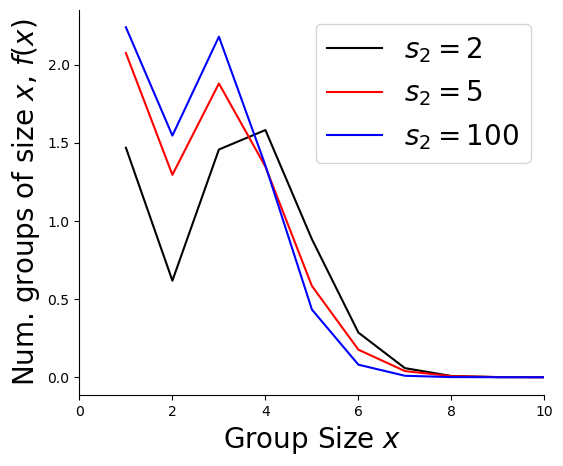

In [128]:
p = 20
M1 = 10; M2 = 10

params = dict(b1=1,b2=0.1,a1 = 1, a2 = 1, h1 = 0.5,h2 = 0.5, α1_of_1 = 0.05, α2_of_1 = 0.95, s1 = 2, s2 = 2,
             δ=0, τx=0.01, r=0,γ=0, x_max=10, d = 2)





param_vec = [2,5,100]
param_key = "s2"
linelabel = r'$s_2=$'+'%d'

fig, ax, full_f_vecs, at_equilibrium, mean_group_size_membership_vec = plot_f_of_x(p, M1, M2,param_vec, param_key, 
                                                                  linelabel, params.copy(), 
                                                                  tsteps = 200, t_f = 2)



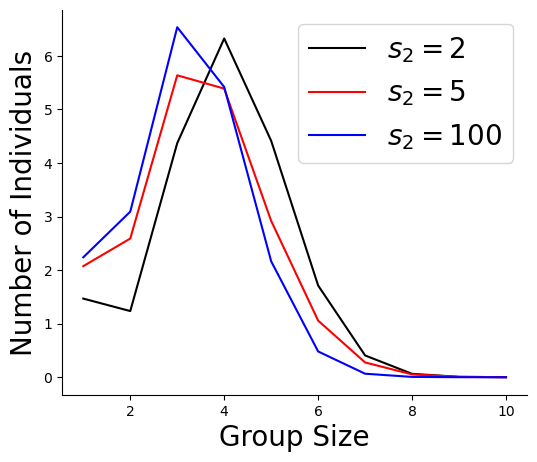

In [129]:
x_max = 10
linelabel = r'$s_2=$'+'%d'
plot_group_membership_hist(param_vec, full_f_vecs, x_max, linelabel)

## Plot Mean Group Size Membership

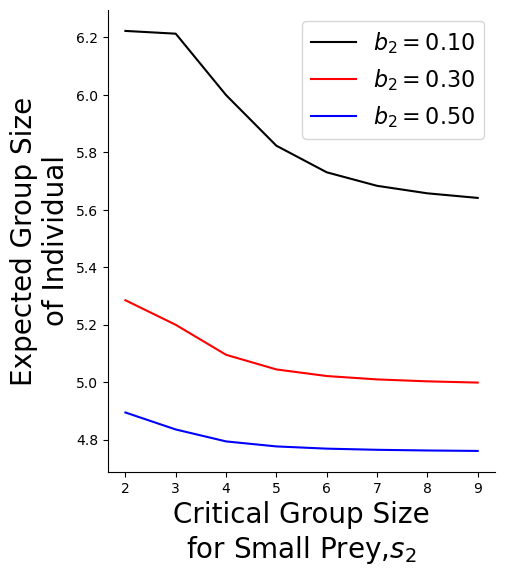

In [122]:
p = 20
M1 = 10; M2 = 10

params = dict(b1=1,b2=0.1,a1 = 1, a2 = 1, h1 = 0.5,h2 = 0.5, α1_of_1 = 0.05, α2_of_1 = 0.95, s1 = 2, s2 = 2,
             δ=0, τx=0.01, r=0,γ=0, x_max=10, d = 2)
param_vec1 = np.arange(2,10,1)
param_key1 = "s2"

param_vec2 = [0.1, 0.3, 0.5]
param_key2 = "b2"
linelabel = r'$b_2=$'+'%.2f'
xlabel = "Critical Group Size\nfor Small Prey," + r'$s_2$'

out = plot_mean_grp_membership_2params(p, M1, M2, param_key1, param_vec1, param_key2, 
                                 param_vec2, params.copy(), linelabel, xlabel, 
                                 tsteps = 100, t_f = 2)
fig, ax, list_at_equilibrium, list_of_meanx = out


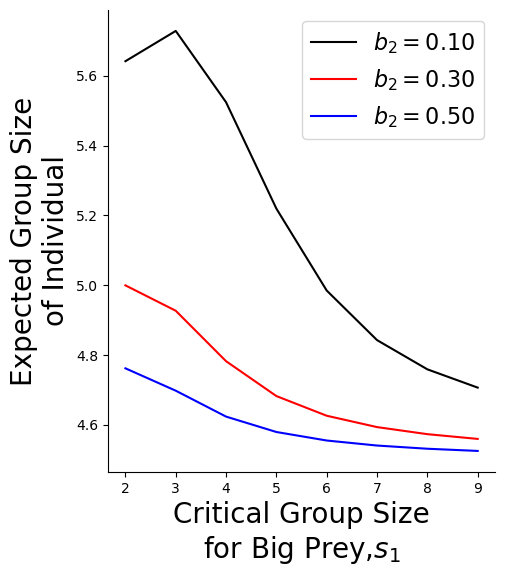

In [131]:
p = 20
M1 = 10; M2 = 10

params = dict(b1=1,b2=0.1,a1 = 1, a2 = 1, h1 = 0.5,h2 = 0.5, α1_of_1 = 0.05, α2_of_1 = 0.95, s1 = 2, s2 = 2,
             δ=0, τx=0.01, r=0,γ=0, x_max=10, d = 2)
param_vec1 = np.arange(2,10,1)
param_key1 = "s1"

param_vec2 = [0.1, 0.3, 0.5]
param_key2 = "b2"
linelabel = r'$b_2=$'+'%.2f'
xlabel = "Critical Group Size\nfor Big Prey," + r'$s_1$'

out = plot_mean_grp_membership_2params(p, M1, M2, param_key1, param_vec1, param_key2, 
                                 param_vec2, params.copy(), linelabel, xlabel, 
                                 tsteps = 100, t_f = 2)
fig, ax, list_at_equilibrium, list_of_meanx = out


## Plot Measures for different $s_2$

In [ ]:
params = dict(b1=1,b2=0.1,a1 = 1, a2 = 1, h1 = 0.5,h2 = 0.5, α1_of_1 = 0.05, α2_of_1 = 0.95, s1 = 2, s2 = 2,
             δ=0, τx=0.01, r=0,γ=0, x_max=10, d = 2)

paramkey = "s2"
param_vals = [2,5,100]
linelabel = r'$s_2 = $ %d'

funhandle = fun_attack_rate
args = [2]
ylabel = r'Capture Probability $\alpha_2(x)$'
fig, ax = plot_measure_vs_grp_size(paramkey, param_vals, linelabel, ylabel, funhandle, args,params.copy())


funhandle = fun_fitness
args = [M1, M2]
ylabel = 'Subordinate Fitness'
fig, ax = plot_measure_vs_grp_size(paramkey, param_vals, linelabel, ylabel, funhandle, args,params.copy())

funhandle = fun_fitness_from_big_prey
args = [M1, M2]
ylabel = 'Subordinate Fitness, Big Prey'
fig, ax = plot_measure_vs_grp_size(paramkey, param_vals, linelabel, ylabel, funhandle, args,params.copy())

funhandle = fun_fitness_from_small_prey
args = [M1, M2]
ylabel = 'Subordinate Fitness, Small Prey'
fig, ax = plot_measure_vs_grp_size(paramkey, param_vals, linelabel, ylabel, funhandle, args,params.copy())



In [ ]:
p = 20
M1 = 10; M2 = 10
f_of_x_vec = np.zeros(9)
params = dict(b1=1,b2=0.1,a1 = 1, a2 = 1, h1 = 0.5,h2 = 0.5, α1_of_1 = 0.05, α2_of_1 = 0.95, s1 = 2, s2 = 2,
             δ=0, τx=0.01, r=0,γ=0, x_max=10, d = 2)


t = np.arange(0,2,0.02)
colors = ['k', 'r', 'b']
fig,ax  = plt.subplots(1,1,figsize = (5,5))
final_f_of_x = [0,0,0]
for i,s in enumerate([2,3,4]):
    params["s1"]=s
    params["s2"]=s
    out = odeint(group_formation_model,f_of_x_vec,t,args=(p, M1, M2, params))
    final_f_of_x[i] = out[-1]
    f_of_1 = fun_f_of_x(1, out[-1], p, **params)
    full_f_vec = [f_of_1, *out[-1]]
    print(colors[i])
    ax.plot(np.arange(1,11,1),full_f_vec,colors[i], label = 's=%d'%s)
ax.set_xlim([0,10])
ax.set_xlabel(r'Group Size $x$', fontsize = 20)
ax.set_ylabel(r'Num. groups of size $x$, $f(x)$', fontsize = 20)
ax.legend(fontsize = 20)


In [ ]:
[mean_group_size_membership_not_solitary(f_vec,p=20,x_max=10) for f_vec in final_f_of_x]

In [ ]:
label = r'$\theta_2=$'+'%d'

In [ ]:
label %θ2

In [ ]:
def mean_grp_membership_versus_param(p, M1, M2,param_vec, param_key, params, tsteps = 200, t_f = 2):

    x_max = params["x_max"]
    f_of_x_vec = np.zeros(x_max - 1)
    t = np.linspace(0,t_f,tsteps)
    final_f_of_x = [0,0,0]
    for i, param in enumerate(param_vec):
        for pkey in param_key:
            params[pkey] = param
        out = odeint(group_formation_model,f_of_x_vec,t,args=(p, M1, M2, params))
        final_f_of_x[i] = out[-1]


    
    return np.array([mean_group_size_membership_not_solitary(f_vec,p,x_max) for f_vec in final_f_of_x])

In [ ]:
p = 20; M1 = 10; M2 = 10
params = dict(b1=1,b2=0.5,a1 = 1, a2 = 1, h1 = 2,h2 = 1, θ1 = 2, θ2 = -2, s1 = 2, s2 = 2,
             δ=0, τx=0.01, r=0.5,γ=0.5, x_max=10, d = 2)

param_key = "θ2"

In [ ]:
p = 20
M1 = 10; M2 = 10
params = dict(b1=1,b2=0.1,a1 = 1, a2 = 1, h1 = 2,h2 = 1, θ1 = 2, θ2 = -2, s1 = 2, s2 = 2,
             δ=0, τx=0.01, r=0.5,γ=0.5, x_max=10, d = 2)

param_vec = [1,2,3]
param_key = ["s1", "s2"]
linelabel = r'$s=$'+'%d'

plot_f_of_x(p, M1, M2,param_vec, param_key, linelabel, params, tsteps = 200, t_f = 2)